<a href="https://colab.research.google.com/github/kurtispykes/deep-learning-examples/blob/main/improving_the_accuracy_of_your_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import typing as t
import numpy as np
import pandas as pd 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 

import warnings
warnings.filterwarnings("ignore")

np.random.seed(25)
tf.random.set_seed(25)

In [4]:
# generate dataset 
X, y = make_classification(
    n_samples=1000,
    n_informative=10,
    n_classes=2,
    random_state=25 
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=25
)

print(f"Train data: {X_train.shape}\n\
Train labels: {y_train.shape}\n\
Test data: {X_test.shape}\n\
Test labels: {y_test.shape}")

Train data: (750, 20)
Train labels: (750,)
Test data: (250, 20)
Test labels: (250,)


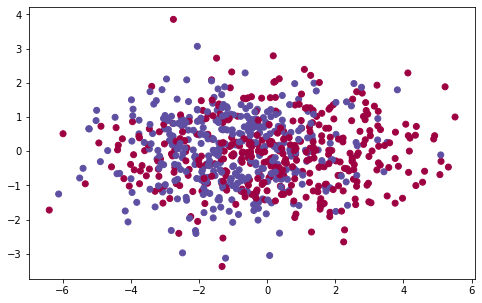

In [6]:
plt.subplots(figsize=(8, 5))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral)
plt.show()

# Baseline

In [8]:
# build 3 layer NN
# 10 neurons in hidden layer with relu activation
# 1 neuron in output layer with sigmoid activation
# adam optimization 
# binary crossentropy loss
# run for 100 epochs

model = tf.keras.Sequential([
                             tf.keras.layers.Dense(10, 
                                                   activation="relu", 
                                                   input_shape=(X_train.shape[1], )),
                             tf.keras.layers.Dense(10,
                                                   activation="relu"),
                             tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=100, validation_data=[X_test, y_test])

Epoch 1/100
24/24 [==============================] - 2s 19ms/step - loss: 0.7061 - accuracy: 0.6253 - val_loss: 0.6596 - val_accuracy: 0.6520
Epoch 2/100
24/24 [==============================] - 0s 6ms/step - loss: 0.6494 - accuracy: 0.6467 - val_loss: 0.6325 - val_accuracy: 0.6680
Epoch 3/100
24/24 [==============================] - 0s 5ms/step - loss: 0.6162 - accuracy: 0.6840 - val_loss: 0.6174 - val_accuracy: 0.6760
Epoch 4/100
24/24 [==============================] - 0s 7ms/step - loss: 0.5922 - accuracy: 0.7027 - val_loss: 0.6045 - val_accuracy: 0.7200
Epoch 5/100
24/24 [==============================] - 0s 6ms/step - loss: 0.5752 - accuracy: 0.7147 - val_loss: 0.5938 - val_accuracy: 0.7360
Epoch 6/100
24/24 [==============================] - 0s 5ms/step - loss: 0.5588 - accuracy: 0.7307 - val_loss: 0.5835 - val_accuracy: 0.7520
Epoch 7/100
24/24 [==============================] - 0s 5ms/step - loss: 0.5450 - accuracy: 0.7400 - val_loss: 0.5757 - val_accuracy: 0.7600
Epoch 8/100


In [10]:
# print train and validation accuracy
print(f"Train accuracy: {history.history.get('accuracy')[-1]}\n\
Test accuracy: {history.history.get('val_accuracy')[-1]}")

Train accuracy: 0.9706666469573975
Test accuracy: 0.8679999709129333


# Ensemble


In [11]:
def create_bootstrap(X, y, size):
  # create an index for each instance 
  idx = [i for i in range(len(X))]
  # create a bootstrap dataset of 7500 instances
  bootstrap_idx = np.random.choice(range(len(X)), size=size)
  # all other instances not in training data 
  # will be used to validate the model
  val_idx = [x for x in idx if x not in bootstrap_idx]
  # creating the training and validation datasets 
  train_data, train_labels = X[bootstrap_idx], y[bootstrap_idx]
  val_data, val_labels = X[val_idx], y[val_idx]
  return train_data, train_labels, val_data, val_labels

def build_model(X, y, X_val, y_val): 
  # building and training model
  model = tf.keras.Sequential([
                              tf.keras.layers.Dense(10, 
                                                    input_shape=(X.shape[1],),
                                                    activation="relu"),
                              tf.keras.layers.Dense(10,
                                                    activation="relu"),
                              tf.keras.layers.Dense(1, activation="sigmoid")
  ])

  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
  model.fit(X, y, epochs=100, verbose=0)
  _, acc = model.evaluate(X_val, y_val, verbose=0)
  return model, acc

def ensemble_predict(test_data, ensemble):
  # combining the models to use on test data
  y_hat = [model.predict(test_data) for model in ensemble]
  # convert preds to binary 
  y_hat = [list(map(lambda x: 0 if x < 0.5 else 1, preds)) for preds in y_hat]
  # taking the most common prediction from each model for each instance
  y_hat_preds = np.array(pd.DataFrame(y_hat).mode().T)
  return y_hat_preds

def train(X, y, n_models, n_samples):
  scores = []
  ensemble = []
  expected_performance = None 
  
  for _ in range(n_models):
    train_data, train_labels, val_data, val_labels = create_bootstrap(
        X, y, n_samples)
    model, acc = build_model(
        train_data, train_labels, val_data, val_labels)
    ensemble.append(model)
    scores.append(acc)
  expected_performance = np.mean(scores)
  return ensemble, scores, expected_performance

ensemble, scores, expected_performance = train(
    X=X_train, 
    y=y_train, 
    n_models=5, 
    n_samples=650)
 

print(f"Accuracy of Constituents: {scores}\n\
Expected Accuracy from Ensemble: {expected_performance}")

Accuracy of Constituents: [0.8871473073959351, 0.859375, 0.856269121170044, 0.8612903356552124, 0.8617363572120667]
Expected Accuracy from Ensemble: 0.8651636242866516


In [12]:
y_hat = ensemble_predict(X_test, ensemble)
print(f"Test accuracy: {accuracy_score(y_test, y_hat)}")

Test accuracy: 0.88


# Regularization (Dropout)

In [13]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(10, 
                                                   activation="relu", 
                                                   input_shape=(X_train.shape[1], )),
                             tf.keras.layers.Dropout(0.5), 
                             tf.keras.layers.Dense(10,
                                                   activation="relu"),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=100, validation_data=[X_test, y_test])

Epoch 1/100
24/24 [==============================] - 1s 10ms/step - loss: 1.2260 - accuracy: 0.5213 - val_loss: 0.8125 - val_accuracy: 0.5400
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 1.1152 - accuracy: 0.5293 - val_loss: 0.7718 - val_accuracy: 0.5480
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 1.1106 - accuracy: 0.5107 - val_loss: 0.7391 - val_accuracy: 0.5520
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 1.0207 - accuracy: 0.5187 - val_loss: 0.7143 - val_accuracy: 0.5600
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 0.9013 - accuracy: 0.5333 - val_loss: 0.6959 - val_accuracy: 0.5640
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 0.9123 - accuracy: 0.5120 - val_loss: 0.6847 - val_accuracy: 0.5720
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 0.9287 - accuracy: 0.4933 - val_loss: 0.6783 - val_accuracy: 0.5640
Epoch 8/100


In [14]:
# print train and validation accuracy
print(f"Train accuracy: {history.history.get('accuracy')[-1]}\n\
Test accuracy: {history.history.get('val_accuracy')[-1]}")

Train accuracy: 0.7493333220481873
Test accuracy: 0.8199999928474426


# Hyperparameter Optimization

In [20]:
learning_rate = [0.001, 0.01, 0.1, 0.3]
units = [5, 10, 50]
dropout = [1.0, 0.8, 0.7, 0.6, 0.5]

param_grid = dict(
    learning_rate=learning_rate, 
    units=units,
    dropout=dropout
)

def create_model(
    units = 1, 
    dropout = 0.5, 
    learning_rate = 0.1):

  opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  
  model = tf.keras.Sequential([
                               tf.keras.layers.Dense(units, 
                                                   activation="relu", 
                                                   input_shape=(X_train.shape[1], )),
                               tf.keras.layers.Dropout(dropout),
                               tf.keras.layers.Dense(units,
                                                   activation="relu"),
                               tf.keras.layers.Dropout(dropout),
                               tf.keras.layers.Dense(1, activation="sigmoid")
                               ])
  
  model.compile(optimizer=opt,
              loss="binary_crossentropy",
              metrics=["accuracy"])
  
  return model 

model = KerasClassifier(build_fn=create_model, verbose=0)

# do grid search 
grid = GridSearchCV(model, param_grid, n_jobs=-1, cv=3)
grid_results = grid.fit(X_train, y_train)

In [21]:
grid_results.best_params_ 

{'dropout': 0.5, 'learning_rate': 0.01, 'units': 50}

In [24]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

model = tf.keras.Sequential([
                             tf.keras.layers.Dense(50, 
                                                   activation="relu", 
                                                   input_shape=(X_train.shape[1], )),
                             tf.keras.layers.Dropout(0.5), 
                             tf.keras.layers.Dense(50,
                                                   activation="relu"),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer=opt,
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=100, validation_data=[X_test, y_test])

Epoch 1/100
24/24 [==============================] - 1s 10ms/step - loss: 0.7855 - accuracy: 0.6267 - val_loss: 0.4970 - val_accuracy: 0.7760
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5155 - accuracy: 0.7360 - val_loss: 0.3904 - val_accuracy: 0.8400
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 0.4615 - accuracy: 0.8013 - val_loss: 0.3581 - val_accuracy: 0.8240
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 0.3803 - accuracy: 0.8387 - val_loss: 0.3186 - val_accuracy: 0.8600
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 0.3608 - accuracy: 0.8507 - val_loss: 0.3260 - val_accuracy: 0.8640
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 0.3387 - accuracy: 0.8667 - val_loss: 0.3373 - val_accuracy: 0.8480
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 0.3245 - accuracy: 0.8587 - val_loss: 0.3250 - val_accuracy: 0.8680
Epoch 8/100


In [25]:
# print train and validation accuracy
print(f"Train accuracy: {history.history.get('accuracy')[-1]}\n\
Test accuracy: {history.history.get('val_accuracy')[-1]}")

Train accuracy: 0.9413333535194397
Test accuracy: 0.8920000195503235
